# Question
Use the Hate Speech dataset in the link below to train a classification model to predict whether a message is Hatespeech, Offensive, or Neither.



## Libraries
These are the libraries I used in the following code

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
from pandas.plotting import scatter_matrix
from matplotlib import cm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score


## Exploratory Data Analysis


### Data Importation

In [2]:
#connect colab to my local files
from google.colab import files

#upload Hate Speech files from my local machine to colab
uploaded = files.upload()


Saving HateSpeech_Kenya.csv to HateSpeech_Kenya.csv


In [3]:
#assign the data to the variable speech
speech = pd.read_csv('HateSpeech_Kenya.csv')

#examine the data
speech.head()

,hate_speech,offensive_language,neither,Class,Tweet
0,0,0,3,0,['The political elite are in desperation. Ordi...
1,0,0,3,0,"[""Am just curious the only people who are call..."
2,0,0,3,0,['USERNAME_3 the area politicians are the one ...
3,0,0,3,0,['War expected in Nakuru if something is not d...
4,0,0,3,0,['USERNAME_4 tells kikuyus activists that they...


### Explore Characteristics of the Dataset

In [ ]:
#examine number of rows and columns
print(speech.shape)

(48076, 5)


In [ ]:
#examine datatypes
print(speech.dtypes)

hate_speech            int64
offensive_language     int64
neither                int64
Class                  int64
Tweet                 object
dtype: object


The sata has 48076 observations and 5 columns.

Of the 5 columns, 4 are numeric (hate_speech, offensive_language, neither, Class), and 1 is character (Tweet)

#### 1. Check for missing values in the dataset
The following code checks for any missing values in the dataset.

In [6]:
#define function for checking missing values
def has_missing_values(speech):
    for row in speech:
        for value in row:
            if not value:
                return True  # Found a missing value
    return False  # No missing values found

#view result
print(has_missing_values(speech))  # Output: True


False


The result is `False`, indicating that the code has no missing values to clean before the analysis.

#### Check for row-by-row duplicates in the dataset
The following code checks for row by row duplicates in the speech dataset.

In [4]:
#define function that checks for row by row duplicates
def has_row_duplicates(speech):
    seen_rows = set()
    for row in speech:
        row_tuple = tuple(row)  # Convert the row to a tuple since lists are unhashable
        if row_tuple in seen_rows:
            return True  # Found a duplicate row
        seen_rows.add(row_tuple)
    return False  # No duplicate rows found

#View results
print(has_row_duplicates(speech))


False


The function returns `False`, indicating that there are no row by row duplicates in this dataset. We can verify this using the following code, that finds duplicates and prints them out.

In [5]:
# Convert the dataset to a set to identify duplicates
seen = set()
duplicates = set()

for item in speech:
    if item in seen:
        duplicates.add(item)
    else:
        seen.add(item)

print("Duplicates:", duplicates)

Duplicates: set()


The set comes out empty, verifying that there are no duplicates in this dataset. There is thus no cleaning necessary before using the data traint he classification models.

### Determine the appropriate response variable

In order to determine which variable is the appropriate target variable, I examined the unique entries in each variable

In [8]:
#examine unique values in cless variable
class_unique = speech['Class'].unique()

#examine unique values in hate_speech variable
hate_unique = speech['hate_speech'].unique()

#examine unique values in offensive_language variable
offense_unique = speech['offensive_language'].unique()

#examine unique values in neither variable
neither_unique = speech['neither'].unique()

#store output and view
res_unique = f"\n Unique values in Class Variable: {class_unique} \n Unique values in Hate Speech Variable: {hate_unique} \n Unique values in Offensive Variable: {offense_unique} \n Unique values in neither Variable: {neither_unique}"
print(res_unique)


 Unique values in Class Variable: [0 1 2] 
 Unique values in Hate Speech Variable: [0 3 4 6 2 1] 
 Unique values in Offensive Variable: [0 3 4 5 1 2 6] 
 Unique values in neither Variable: [3 4 5 6 7 8 0 1 2]


Above the class variable has unique values 0, 1 and 2. According to the description of the dataset on kaggle, these values correspond to:

0 for Neither

1 for Offensive

2 for Hate speech

In [9]:
#check the number of tweets classified in each category
print(speech.groupby('Class').size())

Class
0    36352
1     8543
2     3181
dtype: int64


### Determine the appropriate Input Variables

I omitted the 'tweet' column in my classification analysis as the neither, hate_speech and offensive_language variables offer enough information in terms of input variables.

In [10]:
#drop tweets column
speech2 = speech.drop('Tweet', axis = 1)
speech2.head()

,hate_speech,offensive_language,neither,Class
0,0,0,3,0
1,0,0,3,0
2,0,0,3,0
3,0,0,3,0
4,0,0,3,0


### Visualisation of Input and Target variables

#### 1. Boxplot

I then created a boxplot for each input variable and the target variable as follows



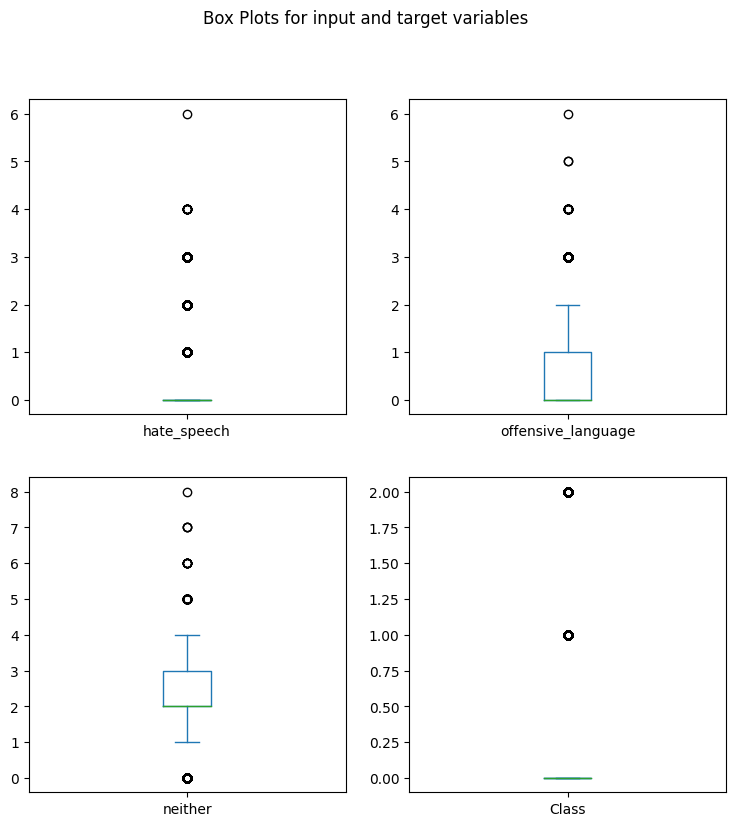

In [11]:
speech2.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False, figsize=(9,9),
                                        title='Box Plots for input and target variables')
plt.savefig('speech_box')
plt.show()

**Interpretation**

The boxplots show that there is the most interquartile deviation in the offensive language category, indicating that tweets scored more widely across the scale ranging from 0-6 in this category. This is followed by the neither category, then the hatespeech category has the least inter-quartile variation. Thus, tweets tend to score around the same in the hatespeech category.

#### 2. Histogram


I also created histograms for the variables as follows

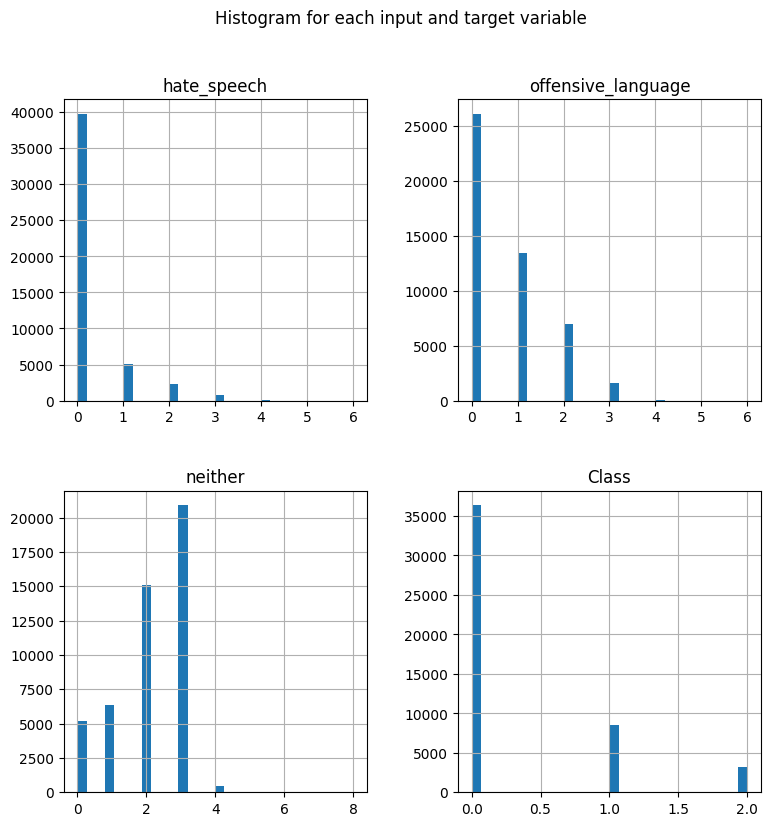

In [12]:
speech2.hist(bins=30, figsize=(9,9))
pl.suptitle("Histogram for each input and target variable")
plt.savefig('speech_hist')
plt.show()

**Interpretation**

1. The histogram for the hate_speech variable is right skewed, with a mode of 0. This indicates that most of the variables score low on being classified as hate-speech.

2. The histogram for offensive language is right skewed as wel but less severely than the hate_speech variable. This indicates that the mean and mode of the observations tends to be on the lower end of the scale from 0-6. Thus, less tweets are found to be offensive in nature.

3. The histogram is left skewed, with a mode of 3. There are few values from the sclae value 4-8, indicating tweets tended to score lower on the neither category.

4. The histogram shows the distribution of classes, with 0 as neither, 1 as offensive and 2 as hate speech. The distribution shows most tweets are found to be neither offensive nor hate speech, followed by offensive and finally hatespeech has the least number of tweets in its category.  

### Scaling, and Creating Training and Testing Datasets

First I examined the numeric variables to determine whether they have the same scale

In [14]:
speech2.describe()

,hate_speech,offensive_language,neither,Class
count,48076.000000,48076.000000,48076.000000,48076.000000
mean,0.256719,0.669690,2.110138,0.310030
std,0.628820,0.846868,1.020536,0.588431
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,0.000000
50%,0.000000,0.000000,2.000000,0.000000
75%,0.000000,1.000000,3.000000,0.000000
max,6.000000,6.000000,8.000000,2.000000


The numerical values do not have the same scale thus we will need to apply scaling to the test set.

In [15]:
#create training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#sclae the datasets
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Classification Algorithms
I trained 6 classification algorithms to compare their performance. Namely, the algorithms are:

1. Logistic Regression
2. Decision tree algorithm
3. Knearest neighbour algorithm.
4. Linear Discriminant analysis algorithm.
5. Gaussian Naive Bayes algorithm.
6. Support Vector Machine.

### 1. Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 1.00
Accuracy of Logistic regression classifier on test set: 1.00


### 2. Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 1.00


### 3. Knearest Neighbour

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 1.00


### 4. Linear DIscriminant Analysis

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 1.00
Accuracy of LDA classifier on test set: 1.00


### 5. Gaussian Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 1.00
Accuracy of GNB classifier on test set: 1.00


### 6. Support Vector Machine

In [21]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 1.00
Accuracy of SVM classifier on test set: 1.00


## Accuracy Testing
All the algorithms score an accuracy of $100\%$ on the testing and training sets, which is perfect performance.

In this section, I chose the logistic regression model to analyse in terms of accuracy, precision and recall. As the models perform similarly in terms of accuracy, the results can be extrapolated to relate to all the models trained.

In [23]:

# calling the SVC classifier
svm = SVC()
svm.fit(X_train, y_train)

# Obtain predictions on the test set
predictions = svm.predict(X_test)

# Print the accuracy of the classifier on the training and test sets
print('Accuracy of SVM classifier on training set: {:.2f}'.format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svm.score(X_test, y_test)))

# Print the predictions and actual labels
print("Predictions:", predictions)
print("Actual labels:", y_test)


Accuracy of SVM classifier on training set: 1.00
Accuracy of SVM classifier on test set: 1.00
Predictions: [1 0 1 ... 0 0 0]
Actual labels: 30237    1
17979    0
32759    1
28641    1
29464    1
        ..
44533    0
4232     0
19346    0
10482    0
38563    0
Name: Class, Length: 12019, dtype: int64


### Accuracy
Accuracy measures the proportion of true results (both true positives and true negatives) among the total number of cases examined.
Mathematically, it is calculated as:
$$Accuracy = \frac{TP +TN}{TP + TN + FP + FN}  $$
Where:
- TP - number of true positives
- TN - number of true negatives
- FP - number of false positives
- FN - number of false negatives

In python, we can use the `accuracy_score` function

In [25]:
# Accuracy
accuracy = accuracy_score(y_test, predictions)

#print
print("Accuracy:", accuracy)

Accuracy: 1.0


### Precision

Precision measures the accuracy of positive predictions.

Mathematically, it is calculated as:
Precision=TPTP+FP

Where:

    TP - number of true positives
    FP - number of false positives

In python, we can use the precision_score function


In [29]:
# Precision
precision = precision_score(y_test, predictions, average = 'micro')

#print
print("Precision:", precision)

Precision: 1.0


### Recall

Recall, also known as sensitivity or true positive rate (TPR), measures the ability of the classifier to find all the positive samples.

Mathematically, it is calculated as:
$$ Recall = \frac{TP}{TP+FN}$$

Where:
- TP - number of true positives
- FN - number of false negatives

In python, we can use the `recall_score` function.

In [31]:
# Recall
recall = recall_score(y_test, predictions, average = 'micro')

#print
print("Recall:", recall)

Recall: 1.0


The accuracy metrics all yield a score of $100\%$, which indicates that the classification models all perform with perfect accuracy on the hate speech dataset.